In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
Xy_numu = np.load("Xy_numu_sel5.npz")
Xy_nue = np.load("Xy_nue.sel5.npz")

In [3]:
X_numu = Xy_numu["x"]
y_numu = Xy_numu["y"]

In [4]:
X_nue = Xy_nue["x"]
y_nue = Xy_nue["y"]

np.save("X_numu.npy",X_numu)
np.save("Y_numu.npy",Y_numu)
np.save("X_nue.npy",X_nue)
np.save("Y_nue.npy",Y_nue)

In [5]:
print('X_numu: ', X_numu.shape, 'X_nue: ', X_nue.shape, 'y_numu: ', y_numu.shape, 'y_nue: ', y_nue.shape)

('X_numu: ', (1494, 75, 16, 15, 18), 'X_nue: ', (1071, 75, 16, 15, 18), 'y_numu: ', (1494,), 'y_nue: ', (1071,))


In [6]:
X = np.vstack((X_numu, X_nue))

In [7]:
y = np.hstack((y_numu, y_nue))

In [8]:
import keras

Using TensorFlow backend.


In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [10]:
get_available_gpus()

[u'/gpu:0']

In [11]:
keras.backend.image_data_format()

'channels_first'

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [13]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

In [14]:
from history_plot import history_plot

In [15]:
print("X size: %d, y size: %d" %(X.shape[0], y.shape[0]) )

X size: 2565, y size: 2565


In [16]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [17]:
print(X_train.shape, y_train.shape, indx_train.shape)
print(X_test.shape, y_test.shape, indx_test.shape)

((2052, 75, 16, 15, 18), (2052,), (2052,))
((513, 75, 16, 15, 18), (513,), (513,))


In [18]:
# Check that Stratification worked
print(y[y==0].shape, y_train[y_train==0].shape, y_test[y_test==0].shape)
print(y[y==1].shape, y_train[y_train==1].shape, y_test[y_test==1].shape)

((1071,), (857,), (214,))
((1494,), (1195,), (299,))


In [19]:
img_channel = X_train.shape[1]
conv_dim_1 = X_train.shape[2]
conv_dim_2 = X_train.shape[3]
conv_dim_3 = X_train.shape[4]
inputshape = (img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(inputshape)

(75, 16, 15, 18)


##### Setup Model Callbacks

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)
reduce_lr_noval = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

#### Create Deep Network Model

In [21]:
def cnn_model(num_classes, optimizer):
    model = Sequential()
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', input_shape=inputshape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [22]:
from keras.backend import clear_session

def cross_validation_score(K, N, X_train, y_train, f_model, f_args, fit_args):
    """"""
    iteration_tr_score = list()
    iteration_val_score = list()
    histories_cnn = list()
    
    def iteration_metrics(scores):
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return mean_score, min_score, max_score
    
    for iteration in range(N):
        tr_accuracy_scores = list()
        val_accuracy_scores=list()
        
        skf = StratifiedKFold(n_splits=K, random_state=iteration)
        
        for i, (train_index, validation_index) in enumerate(skf.split(X_train, y_train)):
            print("[Iteration %d/%d] Test nr.: %d/%d" % (iteration+1, N, i+1, K))
            
            Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
            ytrain, yvalidation = y_train[train_index], y_train[validation_index]

            model = f_model(**f_args)
            
            if iteration == 0 and i == 0:
                model.summary()
            
            Ytrain = to_categorical(ytrain)
            Yvalidation = to_categorical(yvalidation)
            history = model.fit(Xtrain, Ytrain, validation_data = (Xvalidation, Yvalidation), 
                                shuffle=False, **fit_args) 
                        
            histories_cnn.append(history)
            training_acc = history.history['acc'][-1]
            validation_acc = history.history['val_acc'][-1]
            
            print("\nTraining acc: %f, Validation acc: %f\n" %(training_acc,validation_acc))
            tr_accuracy_scores.append(training_acc)
            val_accuracy_scores.append(validation_acc)
            
        iteration_tr_score.append(iteration_metrics(tr_accuracy_scores))
        iteration_val_score.append(iteration_metrics(val_accuracy_scores))
        
    clear_session()
        
    print("Training metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_tr_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))
    
    print("Validation metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_val_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))

    return histories_cnn

In [23]:
n_splits = 3
n_iterations = 2
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info = cross_validation_score(K=n_splits, N=n_iterations, X_train=X_train, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

1369/1369 [==============================] - 7s - loss: 0.0995 - acc: 0.9686 - val_loss: 0.2872 - val_acc: 0.9297
Epoch 16/30
1369/1369 [==============================] - 7s - loss: 0.0959 - acc: 0.9693 - val_loss: 0.2769 - val_acc: 0.9356
Epoch 17/30
1369/1369 [==============================] - 7s - loss: 0.0848 - acc: 0.9715 - val_loss: 0.2931 - val_acc: 0.9312
Epoch 00016: early stopping

Training acc: 0.971512, Validation acc: 0.931186

Training metrics: 
ITER 	 MEAN 	 MIN 	 MAX
1 	 0.971 	 0.958 	 0.982
2 	 0.975 	 0.971 	 0.982
Validation metrics: 
ITER 	 MEAN 	 MIN 	 MAX
1 	 0.926 	 0.915 	 0.943
2 	 0.932 	 0.918 	 0.946


In [29]:
import history_plot
reload(history_plot)
len(history_info)

6

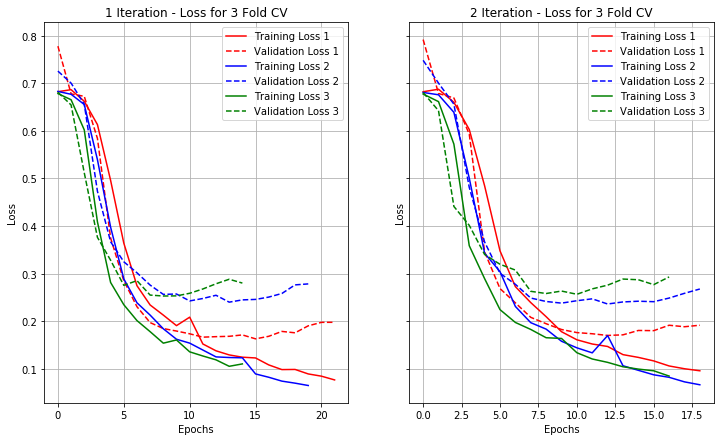

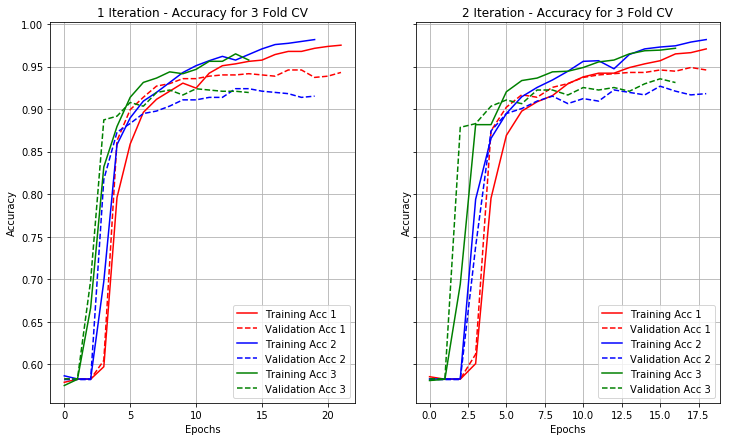

In [32]:
% matplotlib inline
history_plot.history_plot_cv(history_info,"", "show", K=n_splits, N=n_iterations)

In [26]:
Ytrain = to_categorical(y_train)
batch = 64
epochs = 30
print("Train model on the whole train dataset - no validation")
model=cnn_model(num_classes= 2, optimizer=keras.optimizers.Adadelta())
repl_history = model.fit(X_train, Ytrain, batch_size=batch, epochs=epochs, callbacks=[early_stop_noval])  # replicate conf.


Train model on the whole train dataset - no validation
Epoch 1/30
2052/2052 [==============================] - 10s - loss: 0.6820 - acc: 0.5755    
Epoch 2/30
2052/2052 [==============================] - 9s - loss: 0.6402 - acc: 0.6038     
Epoch 3/30
2052/2052 [==============================] - 9s - loss: 0.4385 - acc: 0.8533     
Epoch 4/30
2052/2052 [==============================] - 9s - loss: 0.3012 - acc: 0.8850     
Epoch 5/30
2052/2052 [==============================] - 9s - loss: 0.2229 - acc: 0.9147     
Epoch 6/30
2052/2052 [==============================] - 9s - loss: 0.2020 - acc: 0.9293     
Epoch 7/30
2052/2052 [==============================] - 9s - loss: 0.1840 - acc: 0.9303     
Epoch 8/30
2052/2052 [==============================] - 9s - loss: 0.1694 - acc: 0.9396     
Epoch 9/30
2052/2052 [==============================] - 9s - loss: 0.1586 - acc: 0.9430     
Epoch 10/30
2052/2052 [==============================] - 9s - loss: 0.1296 - acc: 0.9542     
Epoch 11/30
20

In [33]:
print("Use model to make prediction on test data")
predictions = model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, cls_predictions)
print("Accuracy score: ", score)

Use model to make prediction on test data
('Accuracy score: ', 0.93567251461988299)


In [34]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
wrong_class_evt = indx_test[np.where(cls_predictions!=y_test)]
print(wrong_class_evt)
print("{} misclassified events out of {} --> {}%".format(wrong_class_evt.size,y_test.size,
                                                            np.true_divide((y_test.size-wrong_class_evt.size),y_test.size)))


Confusion matrix: 
[[195  19]
 [ 14 285]]
indices of the wrongly classified events: 
[2449  675 1650 1886 1953 1546 2004 1870 1912 2552 1529 2312  470 2357  551
 1891 2514 2273 1013 2133  215  441  875 1003 1965 1683 1491  730 2291   46
  947 1101   40]
33 misclassified events out of 513 --> 0.93567251462%


In [55]:
wrong_class_evt_numu = wrong_class_evt[wrong_class_evt<X_numu.shape[0]]

In [56]:
wrong_class_evt_nue = wrong_class_evt[wrong_class_evt>X_numu.shape[0]] - X_numu.shape[0]

In [57]:
print(wrong_class_evt_numu, wrong_class_evt_nue)

(array([ 675,  470,  551, 1013,  215,  441,  875, 1003, 1491,  730,   46,
        947, 1101,   40]), array([ 955,  156,  392,  459,   52,  510,  376,  418, 1058,   35,  818,
        863,  397, 1020,  779,  639,  471,  189,  797]))


In [38]:
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"

In [39]:
import ROOT
import root_numpy as rnp

In [41]:
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')


E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])

E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])


In [58]:
E_numu_[wrong_class_evt_numu]
E_nue_[wrong_class_evt_nue]

array([  1.14757000e+05,   9.78496000e+02,   4.98240000e+02,
         4.93355000e+03,   2.50308000e+02,   1.57173000e+03,
         7.32269000e+02,   1.32913000e+03,   1.02405000e+06,
         4.81221000e+02,   2.95633000e+04,   8.77295000e+03,
         1.35398000e+03,   1.39607000e+05,   1.47301000e+04,
         8.85677000e+03,   9.91460000e+01,   3.32351000e+02,
         1.91114000e+04])

In [59]:
nbins = 12
log_MC_en = np.log10(E_numu_) 
log_minE = np.min(log_MC_en) #np.log10(np.int(np.min(montecarlo_energies)))
log_maxE = np.max(log_MC_en) #np.log10(np.int(np.max(montecarlo_energies)))
        
log_evts = np.log10(wrong_class_evt_numu) 
    #binned log energies calculation with np.histogram
MC_events_per_bin, _ = np.histogram(log_MC_en, bins=nbins, range=(log_minE, log_maxE))
wrong_evts_per_bin, energy_bins = np.histogram(log_evts, bins=nbins, range=(log_minE,log_maxE))

In [60]:
fraction = np.true_divide(wrong_evts_per_bin, MC_events_per_bin)

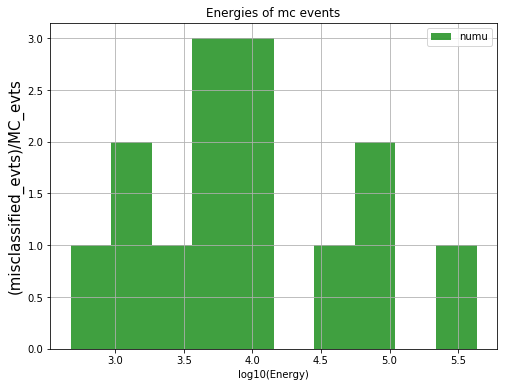

In [61]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(np.log10(E_numu_[wrong_class_evt_numu]), normed=False, facecolor='g', alpha=0.75, label="numu")
#plt.hist(np.log10(E_nue_[wrong_class_evt_nue]), normed=False,  facecolor="blue", alpha=0.5, label="nue")
#plt.hist(np.log10(E_numu_), normed=False, facecolor='b', alpha=0.5, label="numu")
#plt.plot(energy_bins[1:], fraction)

#plt.hist(np.log10(E_numu_), bins=energy_bins)
plt.xlabel("log10(Energy)")
plt.ylabel("(misclassified_evts)/MC_evts", size=15)
plt.xscale("linear")
plt.title('Energies of mc events')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

In [6]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)



In [7]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9, s=40, label="evt {}".format(evt))


In [9]:
wrong_class_evt_numu = np.array([ 675,  470,  551, 1013,  215,  441,  875, 1003, 1491,  730,   46,
        947, 1101,   40])

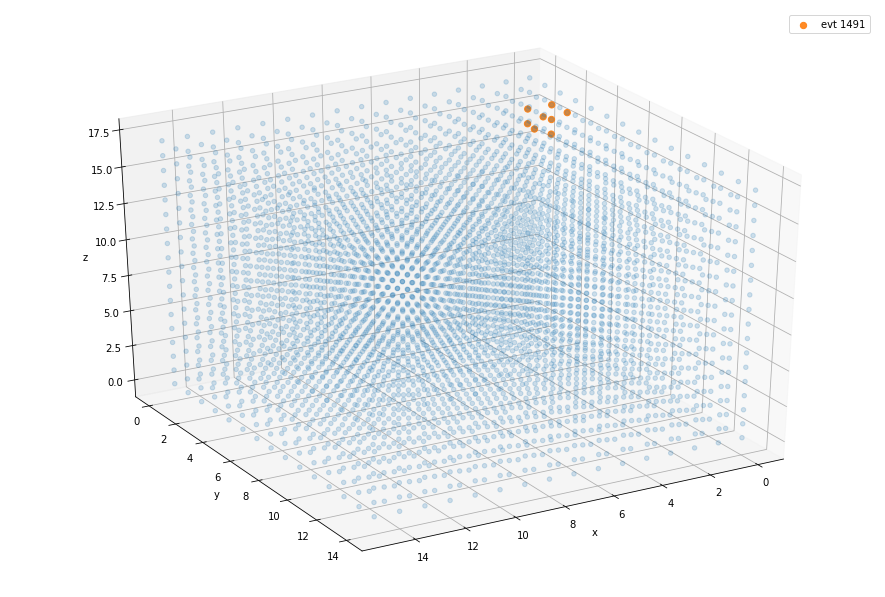

In [16]:

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = Axes3D(fig)

ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#for evt in wrong_class_evt_numu:
#    plot_x_evt(evt)
plot_x_evt(1491)
ax.grid()
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()
